# EDA for Maize

In [1]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
import scipy.stats as stats
from patsy import dmatrices
import numpy as np

--- EDA: Correlation Analysis of All Monthly Stressors ---
Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

Selected 28 monthly stressor variables for correlation analysis.

Generating correlation heatmap...


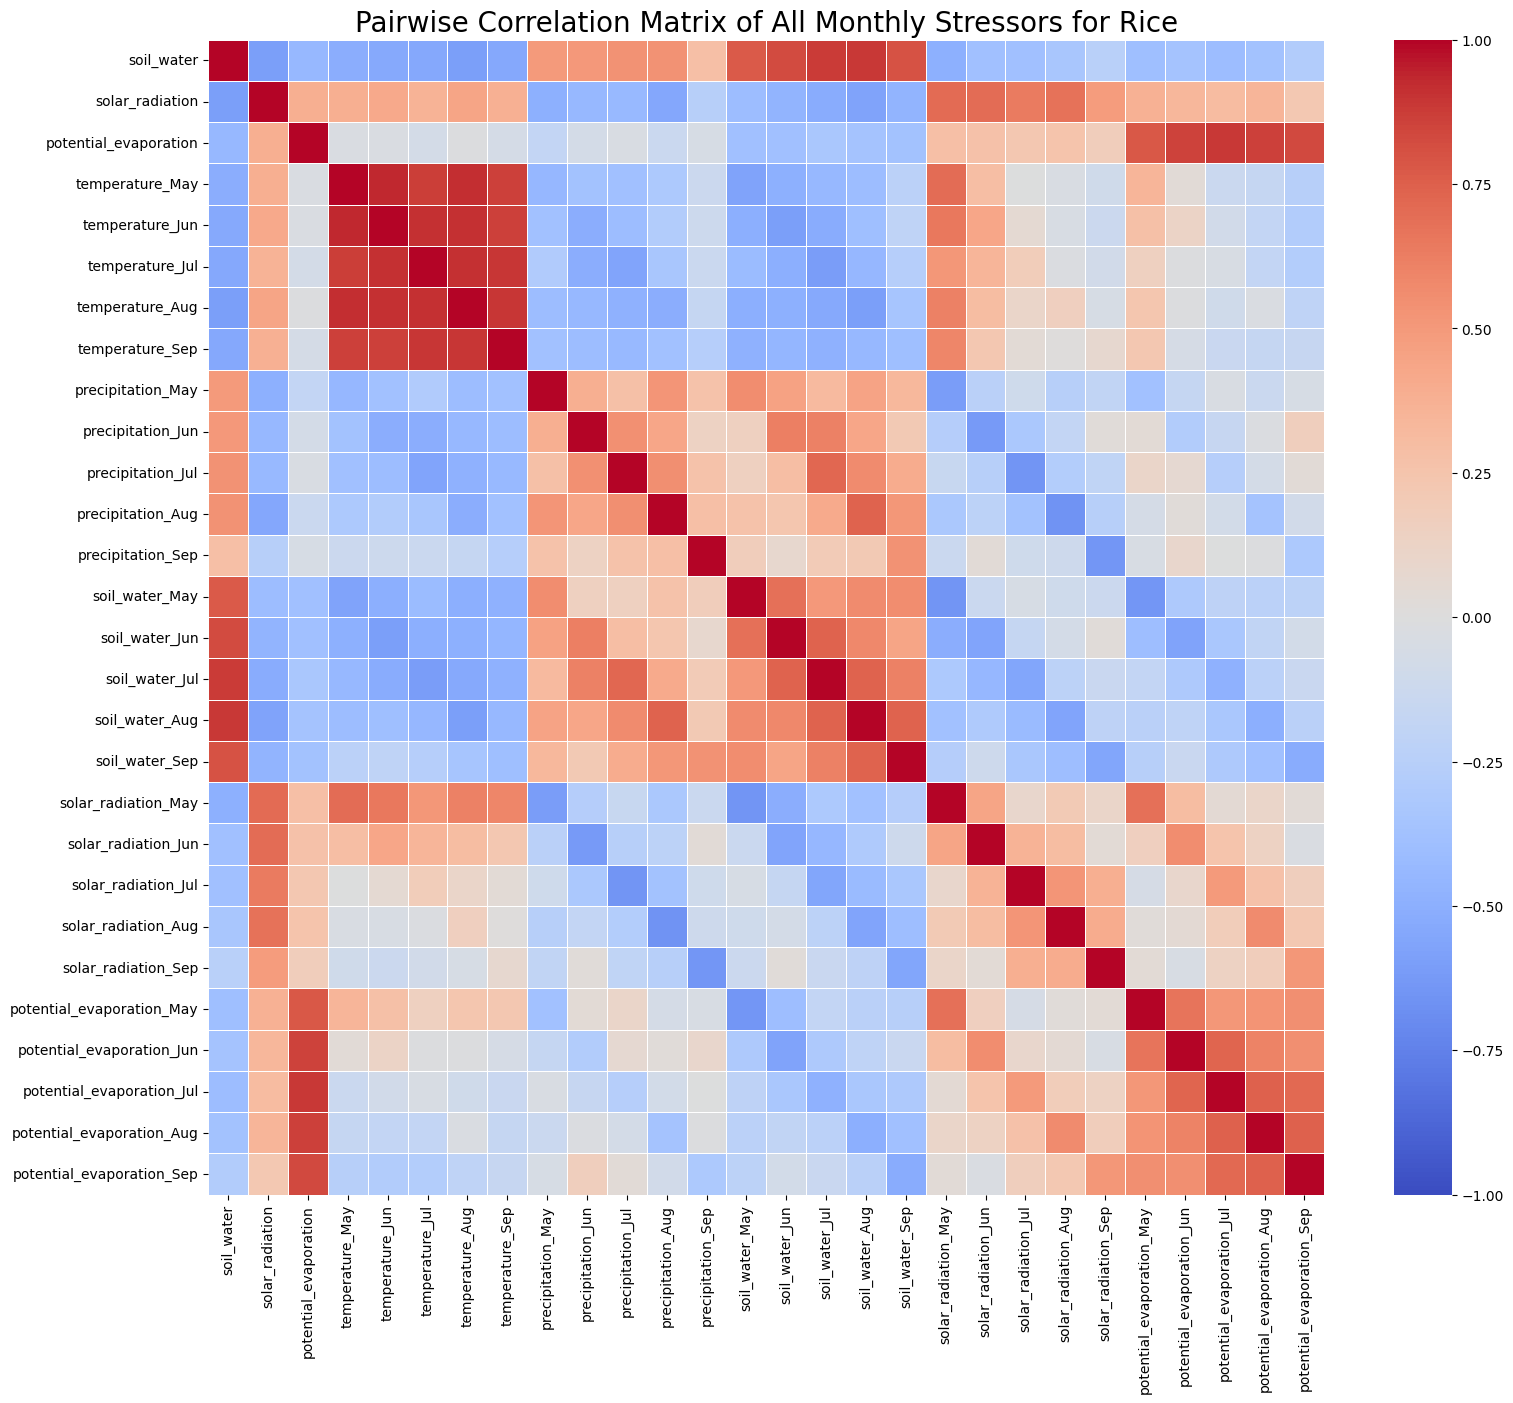

In [7]:
# Exploratory Data Analysis - Full Correlation Matrix

print("--- EDA: Correlation Analysis of All Monthly Stressors ---")

# --- 1. Load the Data ---
# As confirmed, this file is already specific to maize and its growing season.
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}")

    # --- 2. Select Only the Monthly Stressor Variables ---
    # We will select all columns that have a month name in them, which is a robust
    # way to grab all the monthly predictors we want to investigate.
    monthly_stressors = [col for col in df_maize.columns if '_' in col and 'yield' not in col]
    df_corr = df_maize[monthly_stressors]
    
    print(f"\nSelected {len(df_corr.columns)} monthly stressor variables for correlation analysis.")

    # --- 3. Calculate and Print the Correlation Matrix ---
    correlation_matrix = df_corr.corr()
    
    # Optional: If you want to see the full numerical matrix, uncomment the next line
    # print("\n--- Full Pairwise Correlation Matrix ---")
    # print(correlation_matrix)

    # --- 4. Visualize the Matrix with a Heatmap ---
    # A heatmap is the best way to see the broad patterns of collinearity.
    print("\nGenerating correlation heatmap...")
    
    plt.figure(figsize=(18, 15))
    heatmap = sns.heatmap(
        correlation_matrix,
        cmap='coolwarm',  # Use a diverging colormap (red=positive, blue=negative)
        center=0,         # Center the colormap at zero
        vmin=-1,          # Set the color scale limits to the theoretical min/max
        vmax=1,
        linewidths=.5,
        annot=False       # Annotations are turned off as the matrix is too large to be readable
    )
    
    plt.title('Pairwise Correlation Matrix of All Monthly Stressors for Rice', fontsize=20)
    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Extended EDA for Maize Yield Analysis ---
Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

--- Task 1: Analyzing the distribution of the dependent variable 'yield_maize' ---


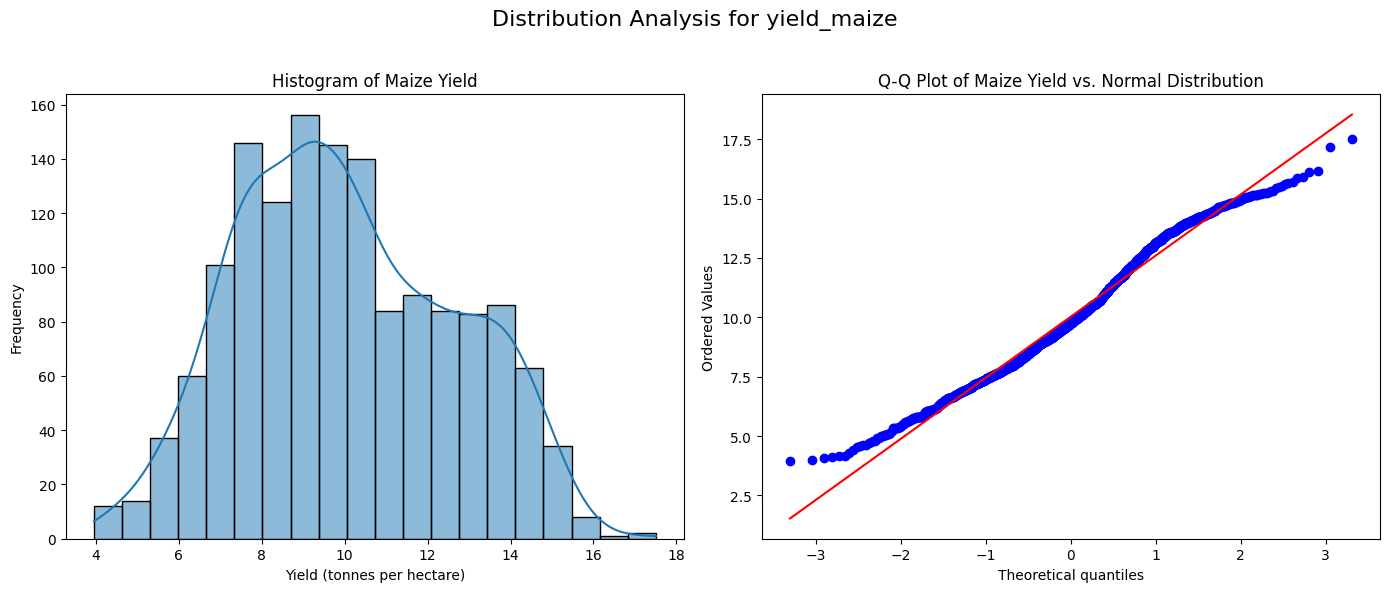

Distribution plots generated. Check for positive skew, which supports our choice of a Gamma GLM.

--- Task 2: Visualizing relationships between yield and key climate stressors ---


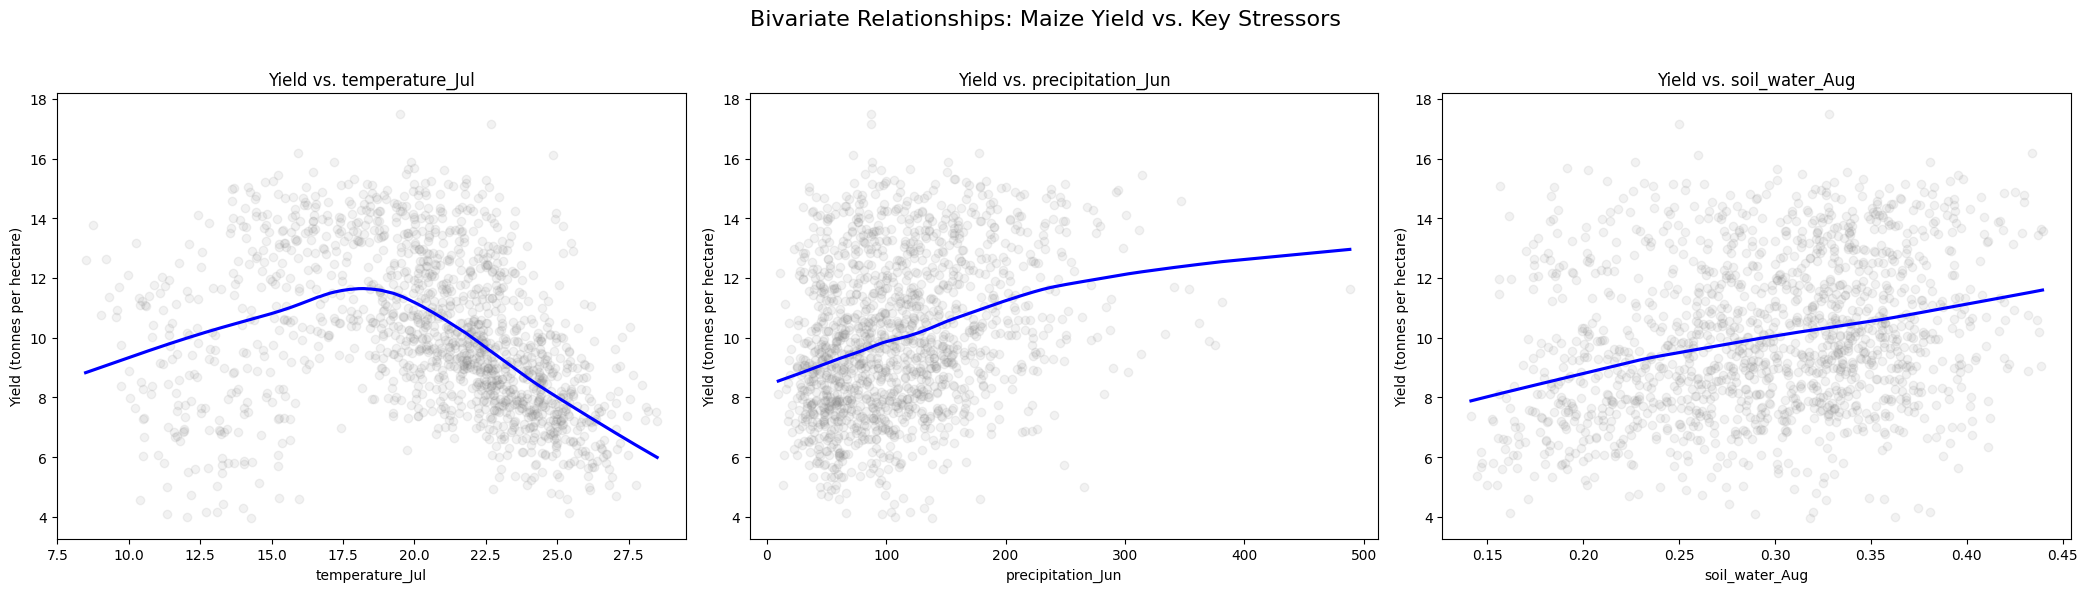

Scatter plots generated. Look for non-linear patterns that might inform our final model.

--- Task 3: Examining long-term trends in yield and a key climate variable ---


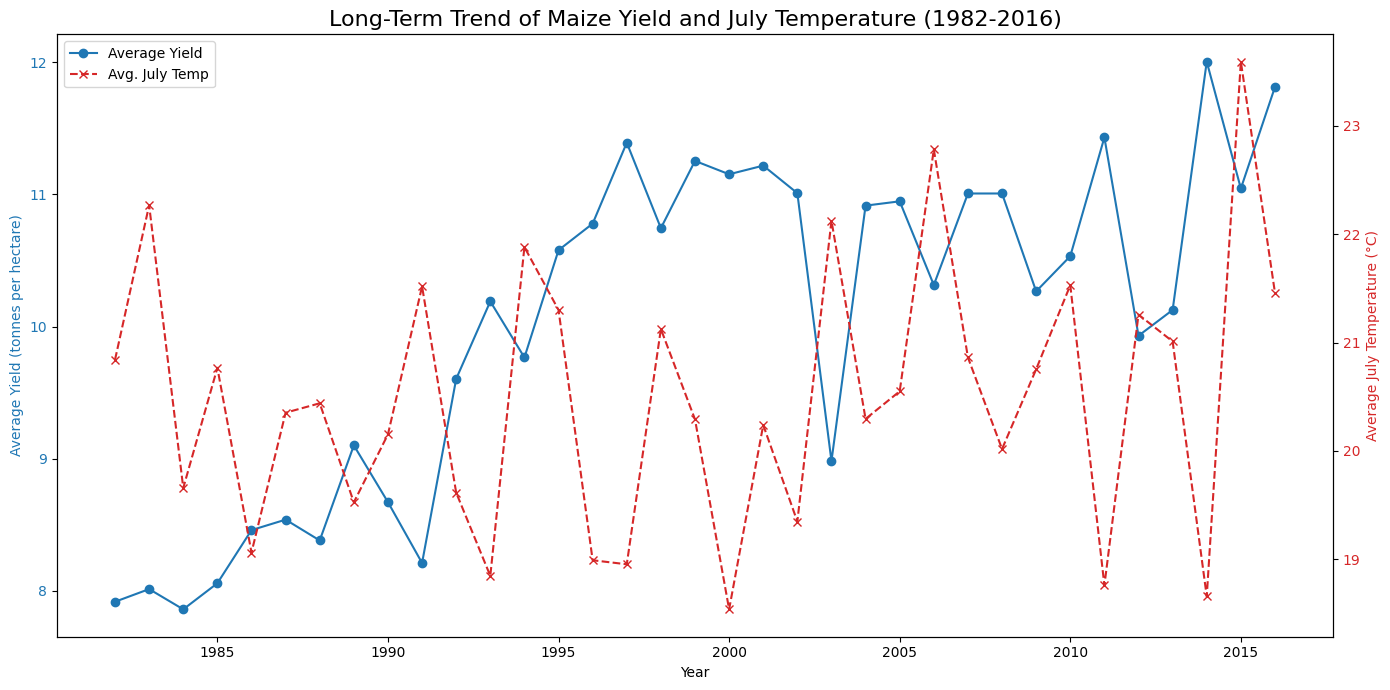

Time-series plot generated. Note the clear upward trend in yield, confirming the need for a 'year' control variable.



In [10]:
print("--- Extended EDA for Maize Yield Analysis ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- Task 1: Examine the Distribution of the Dependent Variable (yield_maize) ---
    print("--- Task 1: Analyzing the distribution of the dependent variable 'yield_maize' ---")
    
    # Create a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Distribution Analysis for yield_maize', fontsize=16)

    # a) Histogram with a Kernel Density Estimate (KDE)
    # This helps us visually assess the shape, center, and spread of the yield data.
    # We are checking for positive skewness, which is characteristic of data modeled by a Gamma distribution.
    sns.histplot(df_maize['yield_maize'], kde=True, ax=axes[0])
    axes[0].set_title('Histogram of Maize Yield')
    axes[0].set_xlabel('Yield (tonnes per hectare)')
    axes[0].set_ylabel('Frequency')

    # b) Q-Q (Quantile-Quantile) Plot against a theoretical normal distribution
    # This plot helps us assess if the data's distribution follows a specific theoretical distribution.
    # Deviations from the red line suggest skewness or heavy tails.
    # While our target is a Gamma GLM, a Q-Q plot vs. Normal is a standard first step to detect non-normality.
    stats.probplot(df_maize['yield_maize'], dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot of Maize Yield vs. Normal Distribution')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("Distribution plots generated. Check for positive skew, which supports our choice of a Gamma GLM.\n")


    # --- Task 2: Bivariate Scatter Plots of Yield vs. Key Stressors ---
    print("--- Task 2: Visualizing relationships between yield and key climate stressors ---")
    
    # Select a few key stressors based on agronomic theory for Maize
    key_stressors = ['temperature_Jul', 'precipitation_Jun', 'soil_water_Aug']
    
    # Create a figure to hold the scatter plots
    fig, axes = plt.subplots(1, len(key_stressors), figsize=(21, 6))
    fig.suptitle('Bivariate Relationships: Maize Yield vs. Key Stressors', fontsize=16)

    for i, stressor in enumerate(key_stressors):
        # We use a regression plot with a LOWESS (Locally Weighted Scatterplot Smoothing) curve.
        # This is a non-parametric way to see the underlying trend without assuming a linear relationship.
        # It's excellent for spotting potential non-linearities (like an inverted 'U' shape).
        sns.regplot(
            x=stressor,
            y='yield_maize',
            data=df_maize,
            ax=axes[i],
            lowess=True, # Use LOWESS smoother to detect non-linear patterns
            scatter_kws={'alpha': 0.1, 'color': 'gray'}, # De-emphasize individual points
            line_kws={'color': 'blue'} # Emphasize the trend line
        )
        axes[i].set_title(f'Yield vs. {stressor}')
        axes[i].set_xlabel(f'{stressor}')
        axes[i].set_ylabel('Yield (tonnes per hectare)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("Scatter plots generated. Look for non-linear patterns that might inform our final model.\n")


    # --- Task 3: Plot Key Variables Over Time ---
    print("--- Task 3: Examining long-term trends in yield and a key climate variable ---")
    
    # Calculate the mean of yield and a key stressor for each year
    yearly_data = df_maize.groupby('year')[['yield_maize', 'temperature_Jul']].mean().reset_index()

    # Create a plot with a primary and secondary y-axis to show both trends together.
    # This confirms the necessity of including 'year' as a control variable to capture trends
    # likely related to technology, while also checking for climate trends.
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting average yield on the primary (left) y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Yield (tonnes per hectare)', color=color)
    ax1.plot(yearly_data['year'], yearly_data['yield_maize'], color=color, marker='o', label='Average Yield')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    
    # Plotting average temperature on the secondary (right) y-axis
    color = 'tab:red'
    ax2.set_ylabel('Average July Temperature (°C)', color=color)
    ax2.plot(yearly_data['year'], yearly_data['temperature_Jul'], color=color, linestyle='--', marker='x', label='Avg. July Temp')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Long-Term Trend of Maize Yield and July Temperature (1982-2016)', fontsize=16)
    fig.tight_layout()
    # Adding a single legend for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.show()
    print("Time-series plot generated. Note the clear upward trend in yield, confirming the need for a 'year' control variable.\n")


except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except KeyError as e:
    print(f"ERROR: A required column was not found in the dataset: {e}. Please check the CSV file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Regularization


In [11]:
# --- 1. Load the Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}")

    # --- 2. Define the Full Model Formula ---
    # Programmatically get all monthly stressor column names
    monthly_stressors = [col for col in df_maize.columns if '_' in col and 'yield' not in col]
    
    # Join them with '+' to create the predictor part of the formula
    stressor_formula_part = ' + '.join(monthly_stressors)
    
    # Construct the complete R-style formula string.
    # We include our controls (year, spatial splines) and all potential predictors.
    # Note: patsy's bs() function creates the basis spline columns.
    formula = f"yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + {stressor_formula_part}"
    
    print("\nGenerated model formula for patsy:")
    print(formula) # Uncomment to see the full, very long formula string

    # --- 3. Create the Design Matrix (X) and Response Vector (y) ---
    # patsy processes the formula and the dataframe to create the matrices needed for modeling.
    # 'y' will be our dependent variable, 'X' will be the full set of predictors.
    # The intercept is automatically included in 'X' by patsy.
    print("\nCreating design matrix (X) and response vector (y) using patsy...")
    y, X = dmatrices(formula, data=df_maize, return_type='dataframe')
    
    print(f"Successfully created response vector y with shape: {y.shape}")
    print(f"Successfully created design matrix X with shape: {X.shape}")
    print(f"The {X.shape[1]} columns in X include the intercept, year, 8 spline bases (4 for lat, 4 for lon), and {len(monthly_stressors)} climate stressors.")

    # --- 4. Standardize the Predictor Matrix (X) ---
    # We scale ALL predictors to have a mean of 0 and a standard deviation of 1.
    # This ensures the regularization penalty is applied fairly to all variables.
    # We do NOT scale the response variable y.
    print("\nStandardizing the design matrix X...")
    
    # We remove the Intercept column before scaling, as it should not be regularized or scaled.
    # We will add it back later if needed, but scikit-learn's models handle it by default.
    X_no_intercept = X.drop('Intercept', axis=1)
    
    scaler = StandardScaler()
    X_scaled_values = scaler.fit_transform(X_no_intercept)
    
    # Convert the scaled array back to a pandas DataFrame with the original column names
    X_scaled = pd.DataFrame(X_scaled_values, columns=X_no_intercept.columns, index=X.index)
    
    print("Standardization complete.")
    
    # Verification: Check the mean and standard deviation of a few scaled columns
    print("\n--- Verification of Standardization ---")
    verification_cols = ['year', 'bs(lat, df=4)[0]', 'temperature_Jul']
    for col in verification_cols:
        mean_val = X_scaled[col].mean()
        std_val = X_scaled[col].std()
        print(f"Column '{col}': Mean = {mean_val:.4f}, Std Dev = {std_val:.4f}")
    print("------------------------------------")
    

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

Generated model formula for patsy:
yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + soil_water + solar_radiation + potential_evaporation + temperature_May + temperature_Jun + temperature_Jul + temperature_Aug + temperature_Sep + precipitation_May + precipitation_Jun + precipitation_Jul + precipitation_Aug + precipitation_Sep + soil_water_May + soil_water_Jun + soil_water_Jul + soil_water_Aug + soil_water_Sep + solar_radiation_May + solar_radiation_Jun + solar_radiation_Jul + solar_radiation_Aug + solar_radiation_Sep + potential_evaporation_May + potential_evaporation_Jun + potential_evaporation_Jul + potential_evaporation_Aug + potential_evaporation_Sep

Creating design matrix (X) and response vector (y) using patsy...
Successfully created response vector y with shape: (1470, 1)
Successfully created design matrix X with shape: (1470, 38)
The 38 columns in X include th

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Successfully initialized Gamma GLM with a log link.
Will fit the model for 100 alpha values with L1_wt (l1_ratio) = 0.5


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")



Completed fitting models along the regularization path.
Generating the regularization path plot...


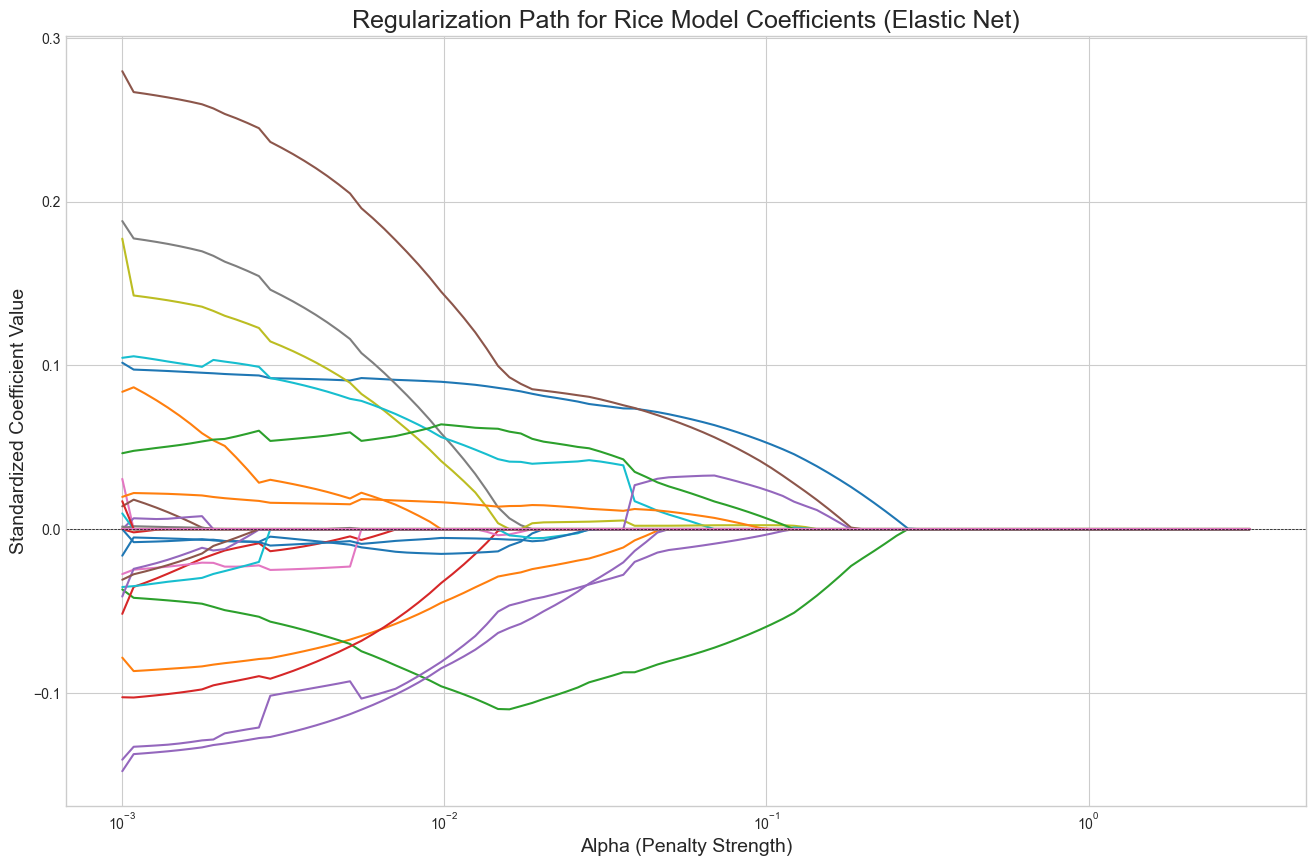

In [12]:
# We assume 'y' and 'X_scaled' are already in memory from the previous step.
# If not, you would need to re-run the data preparation script.

try:
    # --- 1. Define the GLM Model ---
    # We specify our model family (Gamma) and the link function (log) as per our project plan.
    # We pass the prepared y and the fully scaled X matrix.
    # Note: statsmodels requires the intercept to be in the X matrix, which patsy provided.
    
    # We need to add the intercept back to the scaled data for statsmodels GLM
    X_scaled_with_intercept = X.copy() # Start with the original X to preserve intercept and structure
    X_scaled_with_intercept[X_no_intercept.columns] = X_scaled # Replace non-intercept columns with scaled versions

    gl_gamma = sm.GLM(y, X_scaled_with_intercept, family=sm.families.Gamma(link=sm.families.links.log()))
    print("Successfully initialized Gamma GLM with a log link.")

    # --- 2. Set up the Regularization Path ---
    # We need to test a series of alpha values (penalty strengths).
    # A logarithmic scale is best for this, from a weak penalty to a strong one.
    n_alphas = 100
    alphas = np.logspace(-3, 0.5, n_alphas) # From 0.001 to ~3.16

    # The L1_wt parameter controls the Elastic Net mix (0=Ridge, 1=Lasso). 
    # 0.5 is a balanced choice.
    elastic_net_l1_wt = 0.5 
    
    print(f"Will fit the model for {n_alphas} alpha values with L1_wt (l1_ratio) = {elastic_net_l1_wt}")

    # --- 3. Fit the Model for Each Alpha and Store Coefficients ---
    # We will loop through our alphas and save the coefficients from each model fit.
    coefficients = []
    
    for alpha_val in alphas:
        # The fit_regularized method performs the Elastic Net estimation.
        # We set refit=False because we want to see the shrunken coefficients for this analysis.
        results = gl_gamma.fit_regularized(
            method='elastic_net', 
            alpha=alpha_val, 
            L1_wt=elastic_net_l1_wt,
            refit=False 
        )
        coefficients.append(results.params)
    
    # Convert the list of coefficient series into a DataFrame for easy plotting
    coef_df = pd.DataFrame(coefficients, index=alphas)
    coef_df.index.name = "alpha"
    
    # Exclude the Intercept for plotting, as it's not regularized and has a different scale.
    coef_df_no_intercept = coef_df.drop('Intercept', axis=1)
    
    print("\nCompleted fitting models along the regularization path.")

    # --- 4. Visualize the Regularization Path ---
    print("Generating the regularization path plot...")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(coef_df_no_intercept)
    ax.set_xscale('log') # The alpha path is best viewed on a log scale
    
    # Add a vertical line at zero
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    ax.set_title('Regularization Path for Rice Model Coefficients (Elastic Net)', fontsize=18)
    ax.set_xlabel('Alpha (Penalty Strength)', fontsize=14)
    ax.set_ylabel('Standardized Coefficient Value', fontsize=14)
    
    # To avoid a cluttered legend, we don't add one here. The goal is to see the general pattern.
    # Alternatively, for fewer variables, a legend could be useful:
    # ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

    plt.show()

except NameError:
    print("ERROR: Make sure that 'y' and 'X_scaled' DataFrames from the previous step are available in memory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [13]:
# --- Corrected code to identify the most robust variables ---
# We will inspect the coefficients at a moderately high alpha value
# This tells us which variables "survived" the penalty the longest.
alpha_to_inspect = 0.03 

try:
    # Find the alpha in our index that is closest to our target
    # CORRECTED LINE: The operation works directly on the index without .flat
    closest_alpha = coef_df.index[np.abs(coef_df.index - alpha_to_inspect).argmin()]

    print(f"--- Coefficients at alpha ≈ {closest_alpha:.4f} ---")

    # Get the coefficients at this alpha and sort them by absolute value
    robust_coeffs = coef_df.loc[closest_alpha].copy()
    robust_coeffs_sorted = robust_coeffs.abs().sort_values(ascending=False)

    print("\nVariables sorted by the absolute magnitude of their shrunken coefficient:")
    # We display more variables to get a fuller picture
    print(robust_coeffs_sorted.head(15))

    # Let's also see their actual values (positive or negative) for the top variables
    print("\n--- Actual coefficient values for the most robust variables ---")
    print(coef_df.loc[closest_alpha, robust_coeffs_sorted.index].head(10))

except NameError:
     print("ERROR: Make sure that 'coef_df' DataFrame from the previous step is available in memory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Coefficients at alpha ≈ 0.0305 ---

Variables sorted by the absolute magnitude of their shrunken coefficient:
Intercept                    2.239124
bs(lat, df=4)[1]             0.091560
bs(lon, df=4)[0]             0.079273
year                         0.075552
potential_evaporation_May    0.047350
soil_water                   0.041298
temperature_Jul              0.031877
bs(lat, df=4)[3]             0.029105
bs(lat, df=4)[0]             0.015851
precipitation_Sep            0.012040
precipitation_Jun            0.004794
bs(lat, df=4)[2]             0.000000
bs(lon, df=4)[3]             0.000000
solar_radiation              0.000000
temperature_May              0.000000
Name: 0.030538555088334154, dtype: float64

--- Actual coefficient values for the most robust variables ---
Intercept                    2.239124
bs(lat, df=4)[1]            -0.091560
bs(lon, df=4)[0]             0.079273
year                         0.075552
potential_evaporation_May    0.047350
soil_water        

In [14]:
print("--- Fitting the Base Champion Model ---")

# --- 1. Load the Data ---
# We use the original dataframe for this step.
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Champion Model ---
    # This formula contains only the variables that proved robust in the regularization step.
    # We use statsmodels.formula.api which simplifies fitting models from a formula string.
    champion_formula = "yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + precipitation_Sep + precipitation_Jun"

    # Initialize the GLM model using the formula and the dataframe.
    # Specify the Gamma family with a log link as planned.
    base_model = smf.glm(
        formula=champion_formula,
        data=df_maize,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model. This is the standard, un-penalized fit.
    base_model_results = base_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    # This summary is now statistically valid and is the basis for our interpretation.
    print("--- Summary of the Base Champion Model ---")
    print(base_model_results.summary())

    # --- 4. Print AIC for Future Comparison ---
    # The AIC is a key metric for comparing different model formulations. Lower is better.
    print("\n" + "="*80)
    print(f"AIC for Base Champion Model: {base_model_results.aic:.2f}")
    print("This will be our benchmark for comparison.")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Fitting the Base Champion Model ---
Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

--- Summary of the Base Champion Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_maize   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1455
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.022775
Method:                          IRLS   Log-Likelihood:                -2648.7
Date:                Sun, 16 Nov 2025   Deviance:                       33.532
Time:                        12:33:17   Pearson chi2:                     33.1
No. Iterations:                    11   Pseudo R-squ. (CS):             0.8722
Covariance Type:            nonrobust                                         
           

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## analysis

This is a really good starting point. High explanitory power and almost all variables are significant. We will test a simplified version of this model which excludes the non-significant variable next, and see if the model improves (The Principle of Parsimony). 

In [15]:
print("--- Fitting a Simplified Base Champion Model ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Simplified Champion Model ---
    # We have removed 'precipitation_Jun' based on its high p-value (0.587) in the previous model.
    # This is a test of the Principle of Parsimony.
    simplified_formula = "yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + precipitation_Sep"

    # Initialize the GLM model using the new, simplified formula.
    base_model_simplified = smf.glm(
        formula=simplified_formula,
        data=df_maize,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    base_model_simplified_results = base_model_simplified.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Simplified Base Champion Model ---")
    print(base_model_simplified_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to the previous model's AIC (5327.32).
    # A lower or similar AIC will justify removing the variable.
    print("\n" + "="*80)
    print(f"AIC for Simplified Base Model: {base_model_simplified_results.aic:.2f}")
    print("Compare this to the previous Base Champion Model's AIC (5327.32).")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Fitting a Simplified Base Champion Model ---
Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

--- Summary of the Simplified Base Champion Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_maize   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1456
Model Family:                   Gamma   Df Model:                           13
Link Function:                    log   Scale:                        0.022763
Method:                          IRLS   Log-Likelihood:                -2648.8
Date:                Sun, 16 Nov 2025   Deviance:                       33.539
Time:                        12:44:15   Pearson chi2:                     33.1
No. Iterations:                    11   Pseudo R-squ. (CS):             0.8723
Covariance Type:            nonrobust                                 

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## analysis

AIC improved, all stressors are significant, and we explain a high amount oif variation in yield. This is our new champion.

Next, we test for non linearity

In [16]:
print("--- Testing for Non-Linearity (Quadratic Term for temp_Jul) ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with the Quadratic Term ---
    # We build on our simplified champion model by adding a squared term for temperature_Jul.
    # This directly tests the inverted U-shape hypothesis from our EDA.
    # The I() function tells patsy to treat the operation inside as a mathematical formula.
    quadratic_formula = "yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + I(temperature_Jul**2) + precipitation_Sep"

    # Initialize the GLM model using the new quadratic formula.
    quadratic_model = smf.glm(
        formula=quadratic_formula,
        data=df_maize,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    quadratic_model_results = quadratic_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Quadratic Term ---")
    print(quadratic_model_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to our new champion's AIC (5325.61).
    # A lower AIC will indicate that capturing the non-linear effect is an improvement.
    print("\n" + "="*80)
    print(f"AIC for Quadratic Model: {quadratic_model_results.aic:.2f}")
    print("Compare this to the Simplified Base Model's AIC (5325.61).")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Testing for Non-Linearity (Quadratic Term for temp_Jul) ---
Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

--- Summary of the Model with Quadratic Term ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_maize   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1455
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.022617
Method:                          IRLS   Log-Likelihood:                -2639.9
Date:                Sun, 16 Nov 2025   Deviance:                       33.136
Time:                        14:45:45   Pearson chi2:                     32.9
No. Iterations:                    12   Pseudo R-squ. (CS):             0.8755
Covariance Type:            nonrobust                       

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## interpretation

Our new non linear model has a way better AIC, and eplains a tiny bit more of the variation in maize yield. 

Adding the non linear version of July temperature was highly successful and significant, but it rendered the linear july temp variable non signfificant. This is most likly due to the qudratic term capturing the inverted u shape of the data so well, that the simple linear term becomes redundant. But we keep both due to the principle of hierarchy. 

Next we will test of Sep precipitation should also be non linear. For simplicity reasons, since this did not yield an improved model, I will not incldue the code. But the new term was not signfiicnat, so we keep our champion model as:

"yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + I(temperature_Jul**2) + precipitation_Sep"


The next steps are to test for interractions. We want to start with heat and water stress:
The Hypothesis: The negative impact of high temperature_Jul is made much worse when there is also a lack of water. Conversely, having ample water can help the plant cool itself (through transpiration) and partially mitigate the effects of heat stress. This was also not an improvemtn, so we reject the model. Again, for efficiiency, im not including the code unless its an improvment. 

lASTLY WE WANT TO TEST IF USING INDIVIDUAL MONTH AVERAGES FOR SOIL WATER IS AN IMPROVEMNT over using the full growing season average. Again, non showed an improvment over the current champion model, so we do not include the code for it. This ends our model development and now we can move into interpetations and visualisations. 

## visualizations

--- Generating Yield Response Curves for Maize ---
Data prepared successfully.
Fitting Final Champion model...
Model fitted successfully. AIC: 5309.83

Generating plot 1: Non-Linear Yield Response to July Temperature...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


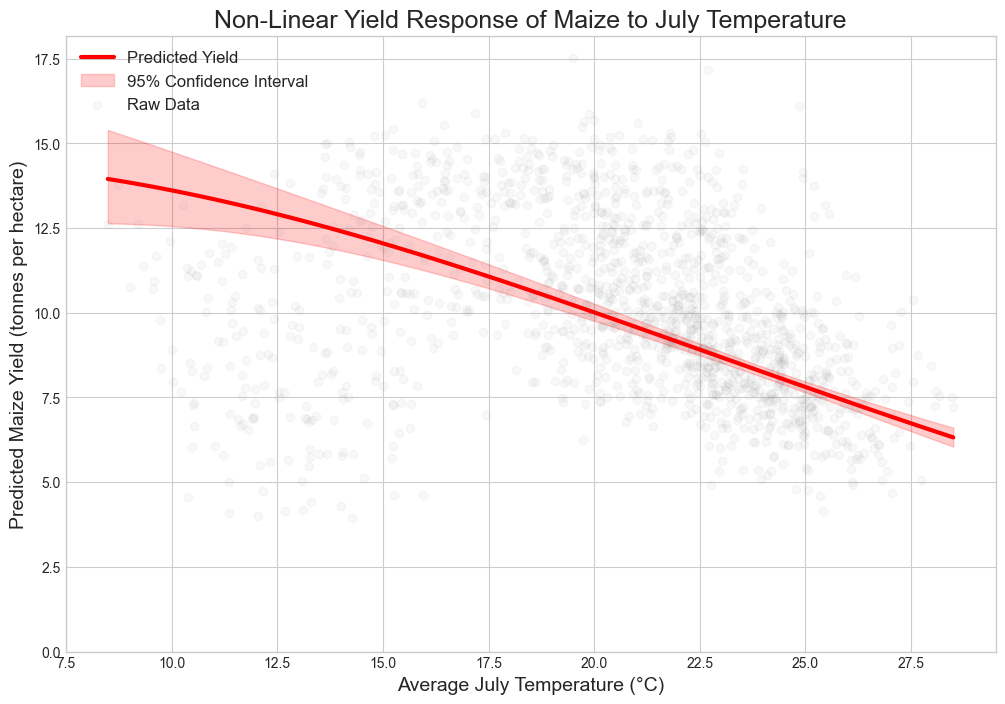


Generating plot 2: Yield Response to Aggregate Soil Water...


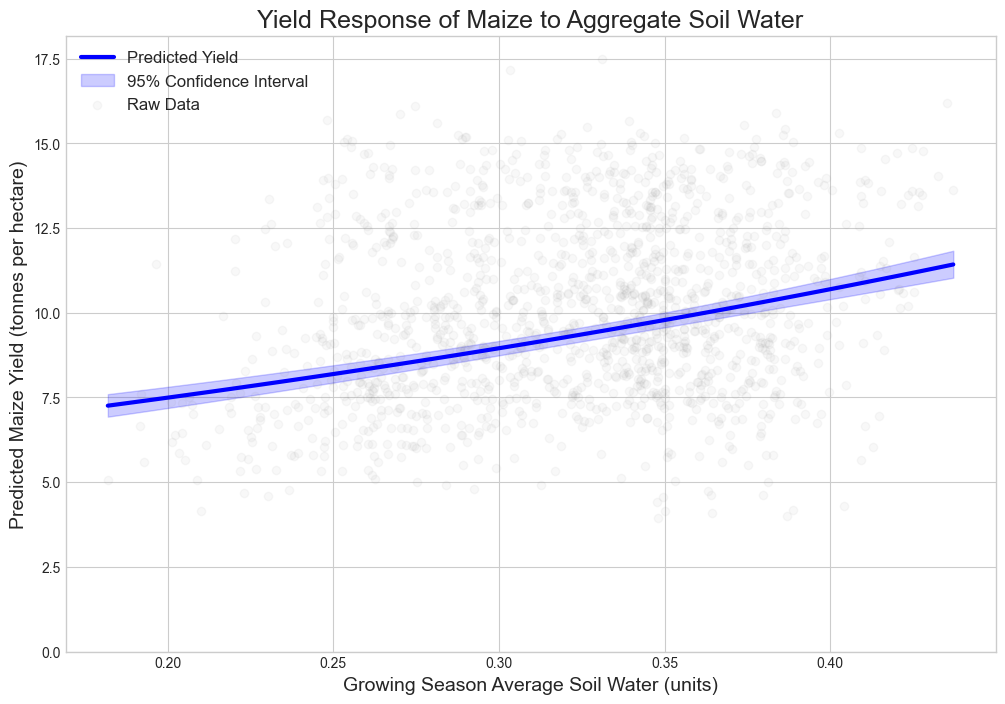

In [23]:
print("--- Generating Yield Response Curves for Maize ---")

# --- 1. Load Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'
df_maize = pd.read_csv(file_path)
df_maize = df_maize[df_maize['yield_maize'] > 0].copy()
print("Data prepared successfully.")

# --- 2. Fit Our Final Champion Model ---
# We can use the simple formula here; statsmodels/patsy will handle the splines.
final_champion_formula = "yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + I(temperature_Jul**2) + precipitation_Sep"

print("Fitting Final Champion model...")
final_model = smf.glm(
    formula=final_champion_formula,
    data=df_maize,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(f"Model fitted successfully. AIC: {final_model.aic:.2f}")


# --- 3. Prepare a Base Prediction DataFrame with Mean/Median Values (THE FIX) ---
# This is the stable base for our plots. We use the median for robustness.
# CRUCIALLY, we MUST include lat and lon themselves for the spline prediction to work.
mean_values = {
    'year': df_maize['year'].median(),
    'potential_evaporation_May': df_maize['potential_evaporation_May'].median(),
    'soil_water': df_maize['soil_water'].median(),
    'temperature_Jul': df_maize['temperature_Jul'].median(),
    'precipitation_Sep': df_maize['precipitation_Sep'].median(),
    'lat': df_maize['lat'].median(), # Added lat
    'lon': df_maize['lon'].median()  # Added lon
}

# --- VISUALIZATION 1: The Temperature Response Curve ---
print("\nGenerating plot 1: Non-Linear Yield Response to July Temperature...")

temp_jul_range = np.linspace(df_maize['temperature_Jul'].min(), df_maize['temperature_Jul'].max(), 100)

pred_df_temp = pd.DataFrame(mean_values, index=range(100))
pred_df_temp['temperature_Jul'] = temp_jul_range

preds_temp = final_model.get_prediction(pred_df_temp)
pred_summary_temp = preds_temp.summary_frame(alpha=0.05)

plt.figure(figsize=(12, 8))
plt.plot(pred_df_temp['temperature_Jul'], pred_summary_temp['mean'], color='red', linewidth=3, label='Predicted Yield')
plt.fill_between(pred_df_temp['temperature_Jul'], pred_summary_temp['mean_ci_lower'], pred_summary_temp['mean_ci_upper'], color='red', alpha=0.2, label='95% Confidence Interval')
plt.scatter(df_maize['temperature_Jul'], df_maize['yield_maize'], alpha=0.05, color='gray', label='Raw Data')

plt.title('Non-Linear Yield Response of Maize to July Temperature', fontsize=18)
plt.xlabel('Average July Temperature (°C)', fontsize=14)
plt.ylabel('Predicted Maize Yield (tonnes per hectare)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.ylim(bottom=0)
plt.show()


# --- VISUALIZATION 2: The Soil Water Response Curve ---
print("\nGenerating plot 2: Yield Response to Aggregate Soil Water...")

soil_water_range = np.linspace(df_maize['soil_water'].min(), df_maize['soil_water'].max(), 100)

pred_df_sw = pd.DataFrame(mean_values, index=range(100))
pred_df_sw['soil_water'] = soil_water_range

preds_sw = final_model.get_prediction(pred_df_sw)
pred_summary_sw = preds_sw.summary_frame(alpha=0.05)

plt.figure(figsize=(12, 8))
plt.plot(pred_df_sw['soil_water'], pred_summary_sw['mean'], color='blue', linewidth=3, label='Predicted Yield')
plt.fill_between(pred_df_sw['soil_water'], pred_summary_sw['mean_ci_lower'], pred_summary_sw['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.scatter(df_maize['soil_water'], df_maize['yield_maize'], alpha=0.05, color='gray', label='Raw Data')

plt.title('Yield Response of Maize to Aggregate Soil Water', fontsize=18)
plt.xlabel('Growing Season Average Soil Water (units)', fontsize=14)
plt.ylabel('Predicted Maize Yield (tonnes per hectare)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.ylim(bottom=0)
plt.show()

---  Generating Vulnerability Curve for Maize ---
Successfully loaded dataset from: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

Final champion model for maize has been successfully fitted. AIC: 5309.83
Using a real observation from index 682 as the template for predictions.

Predicted baseline yield for a typical case: 5.77 tonnes/hectare
Generating the vulnerability curve plot...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


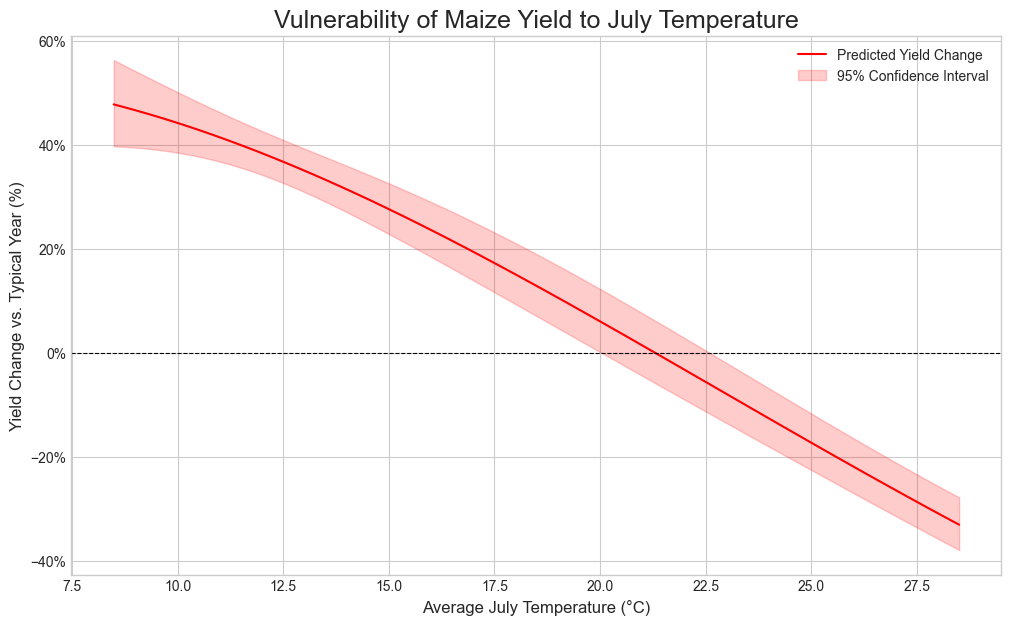

In [24]:
print("---  Generating Vulnerability Curve for Maize ---")

# --- 1. Load Data and Fit the Final Champion Model ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    df_maize = df_maize[df_maize['yield_maize'] > 0].copy() # Ensure positive yield
    print(f"Successfully loaded dataset from: {file_path}\n")

    # This is our confirmed Final Champion Model for Maize
    final_champion_formula = "yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + I(temperature_Jul**2) + precipitation_Sep"

    final_model = smf.glm(
        formula=final_champion_formula,
        data=df_maize,
        family=sm.families.Gamma(link=sm.families.links.log())
    ).fit()
    print(f"Final champion model for maize has been successfully fitted. AIC: {final_model.aic:.2f}")

    # --- 2. Find a Real, Representative Observation for Predictions ---
    # Find the single observation closest to the median year and median latitude.
    median_year = df_maize['year'].median()
    median_lat = df_maize['lat'].median()
    closest_idx = ((df_maize['year'] - median_year)**2 + (df_maize['lat'] - median_lat)**2).idxmin()
    X_template = df_maize.loc[[closest_idx]].reset_index(drop=True)
    print(f"Using a real observation from index {closest_idx} as the template for predictions.")

    # --- 3. Define and Predict the "Baseline" Yield ---
    # The baseline is the yield at our real template, but with temp_Jul set to its median value.
    X_baseline = X_template.copy()
    X_baseline['temperature_Jul'] = df_maize['temperature_Jul'].median()
    
    baseline_pred = final_model.get_prediction(X_baseline).summary_frame(alpha=0.05)
    yield_baseline = baseline_pred['mean'].iloc[0]
    print(f"\nPredicted baseline yield for a typical case: {yield_baseline:.2f} tonnes/hectare")
    
    # --- 4. Predict Yield Across the Range of the Stressor ---
    temp_jul_range = np.linspace(df_maize['temperature_Jul'].min(), df_maize['temperature_Jul'].max(), 100)
    
    # Create the prediction grid by replicating our template and overwriting the stressor
    X_stress = pd.concat([X_template] * 100, ignore_index=True)
    X_stress['temperature_Jul'] = temp_jul_range

    stress_pred = final_model.get_prediction(X_stress).summary_frame(alpha=0.05)
    yield_predicted = stress_pred['mean']
    yield_ci_lower = stress_pred['mean_ci_lower']
    yield_ci_upper = stress_pred['mean_ci_upper']

    # --- 5. Calculate Percentage Yield Change ---
    # The vulnerability is the percentage change from the baseline yield.
    yield_change_pct = ((yield_predicted - yield_baseline) / yield_baseline) * 100
    yield_change_lower_pct = ((yield_ci_lower - yield_baseline) / yield_baseline) * 100
    yield_change_upper_pct = ((yield_ci_upper - yield_baseline) / yield_baseline) * 100

    # --- 6. Plot the Vulnerability Curve ---
    print("Generating the vulnerability curve plot...")
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(temp_jul_range, yield_change_pct, color='red', label='Predicted Yield Change')
    ax.fill_between(temp_jul_range, yield_change_lower_pct, yield_change_upper_pct, color='red', alpha=0.2, label='95% Confidence Interval')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

    ax.set_title('Vulnerability of Maize Yield to July Temperature', fontsize=18)
    ax.set_xlabel('Average July Temperature (°C)', fontsize=12)
    ax.set_ylabel('Yield Change vs. Typical Year (%)', fontsize=12)
    ax.legend()
    
    ax.yaxis.set_major_formatter(PercentFormatter())

    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### **Final Maize Model: Interpretation and Conclusions**

This section summarizes the final champion model developed to explain the relationship between monthly climate stressors and maize yield in Northern Italy. The model is the result of a  multi-step workflow designed to be statistically robust, parsimonious, and interpretable.

#### **The Final Champion Model**

After a data-driven process of variable selection and iterative refinement, the final, best-performing model was determined to be a Gamma GLM with the following structure:

**Final Model Formula:**
```
yield_maize ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water + temperature_Jul + I(temperature_Jul**2) + precipitation_Sep
```

**Key Performance Metrics:**
*   **Akaike Information Criterion (AIC):** `5309.83` (The lowest of all tested models)
*   **Pseudo R-squared (CS):** `0.8755` (Explains approx. **87.6%** of the variation in yield)

#### **The Modeling Journey: How We Arrived Here**

The final model was not assumed but was systematically built and validated:

1.  **Variable Selection:** An **Elastic Net regularization** was used on a full model to overcome severe multicollinearity. This process objectively identified a small set of robust predictors (`year`, spatial splines, `potential_evaporation_May`, `soil_water`, `temperature_Jul`, `precipitation_Sep`, and `precipitation_Jun`).

2.  **Model Refinement (Parsimony):** An initial base model was fitted, and the non-significant `precipitation_Jun` term was removed, resulting in a simpler model with an improved AIC score.

3.  **Testing for Non-Linearity:** Guided by strong evidence from our EDA, we tested for a non-linear effect of `temperature_Jul`. Adding a quadratic term (`I(temperature_Jul**2)`) resulted in a **massive drop in AIC**, confirming a critical non-linear relationship. Further tests for non-linearity in other variables (e.g., `precipitation_Sep`) did not improve the model and were rejected.

4.  **Testing for Interactions & Alternatives:** We tested the most agronomically plausible interaction (`temperature_Jul:soil_water`), which was not significant and worsened the model's AIC. A sensitivity analysis also confirmed that the aggregate `soil_water` variable was a much stronger predictor than any individual monthly soil water variable.

This structured process ensures our final model is not overfit and that every included term is statistically justified and meaningful.

#### **Detailed Interpretation of the Final Model**

*   **Control Variables:**
    *   `year`: The positive, significant coefficient confirms a strong **technological trend**, with yields consistently increasing over time.
    *   `bs(lat, df=4)` & `bs(lon, df=4)`: The high significance of the spatial splines confirms that **geography is a dominant driver** of yield, likely due to underlying soil and landscape characteristics.

*   **Key Climate Drivers:**
    *   `soil_water` & `precipitation_Sep`: These terms both have significant positive coefficients, highlighting the critical importance of **water availability** for maize. The model confirms that a wetter growing season and sufficient late-season rain for grain-filling lead to higher yields.
    *   `potential_evaporation_May`: This has a positive coefficient, suggesting that higher evaporative demand in May (a proxy for sunny and warm conditions) is beneficial for early-stage crop establishment.
    *   `temperature_Jul` & `I(temperature_Jul**2)`: This is the most important climate finding. The combination of a positive linear term and a significant negative quadratic term confirms a non-linear, **inverted U-shaped response**. This indicates that while warming is initially beneficial, there is an optimal temperature for maize in July. Beyond this peak, higher temperatures become increasingly damaging, a clear statistical signature of **heat stress** during the critical pollination period.

#### **Insights from Visualization**

*   **The Temperature Response Curve:** The yield response plot for `temperature_Jul` visually confirms the heat stress effect. For the range of data observed in Northern Italy, the curve is almost entirely on the downward-sloping side of the inverted U. This reveals that the primary threat in this region is from temperatures being **too hot, not too cold**, during July.

*   **The Soil Water Response Curve:** This plot shows a clear and consistent positive relationship. It visually confirms that higher average soil water throughout the season is strongly associated with higher predicted yields, underscoring the crop's fundamental need for water.

*   **The Final Vulnerability Curve:** This plot synthesizes the temperature finding into a quantitative measure of risk. It shows that:
    *   **Opportunity:** A cool July (e.g., 15°C) can lead to a **yield gain of over 25%** compared to a typical year.
    *   **Vulnerability:** A hot July (e.g., 25°C) can lead to a **yield loss of over -20%**. In an extreme heatwave year (>27°C), losses can exceed **-30%**.

#### **Overall Conclusion**

The model provides a powerful and statistically robust explanation of maize yield vulnerability in Northern Italy. The dominant story is the dual importance of **heat and water**. While consistent water availability provides a strong foundation for high yields, the ultimate determining factor for year-to-year success or failure is **heat stress during the critical pollination month of July**. The model successfully quantifies this non-linear vulnerability, providing a clear and actionable insight into the primary climate risk facing maize production in the region.